# 1. Imports, Options and Ingestion

In [1]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

# Spectral Clustering
from scipy.spatial import distance
from gower import gower_matrix
from scipy import linalg
from scipy.linalg import svd
from sklearn.preprocessing import normalize

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
path = '../../data/'

In [4]:
# Reading the csv data
regulars = pd.read_csv(f'{path}rfm_regulars.csv', index_col=0)

# 2. Spectral

In [5]:
# Define the features of interest, and take a sample

rbf_param = 3.141542 
n_cluster = 3

n_samples = 4000
random_state = 1
target_features = [
    'per_chain_order'
    , 'log_total_amt'
    , 'avg_amt_per_product'
    , 'n_cuisines'
    , 'cust_city_2.0', 'cust_city_4.0', 'cust_city_8.0'
]
n_features = len(target_features)

spectral_df = regulars[target_features].copy().sample(n=n_samples, random_state=random_state) 
arr_spectral_df = spectral_df.values

In [6]:
class SpectralCluster:
    def __init__(self, rbf_param, n_clusters):
        self.rbf_param = rbf_param
        self.n_clusters = n_clusters
        self.kmeans = None
        self.gower_dist = None
    
    def fit(self, data):
        """Fit the model using the provided Gower distance matrix."""
        self.gower_dist = gower_matrix(data)
        K = np.exp(-self.rbf_param * self.gower_dist)
        D = K.sum(axis=1)
        D = np.sqrt(1 / D)
        M = np.multiply(D[np.newaxis, :], np.multiply(K, D[np.newaxis, :]))
        
        U, _, _ = svd(M, full_matrices=False, lapack_driver="gesvd")
        Usubset = U[:, :self.n_clusters]
        self.kmeans = KMeans(n_clusters=self.n_clusters).fit(normalize(Usubset))
 
    def predict(self, data_point_index):
        """Predict the cluster label for a specific data point."""
        if self.kmeans is None:
            raise ValueError("Model has not been fitted yet.")
        return self.kmeans.labels_[data_point_index]
    


['spectral_clustering.pkl']

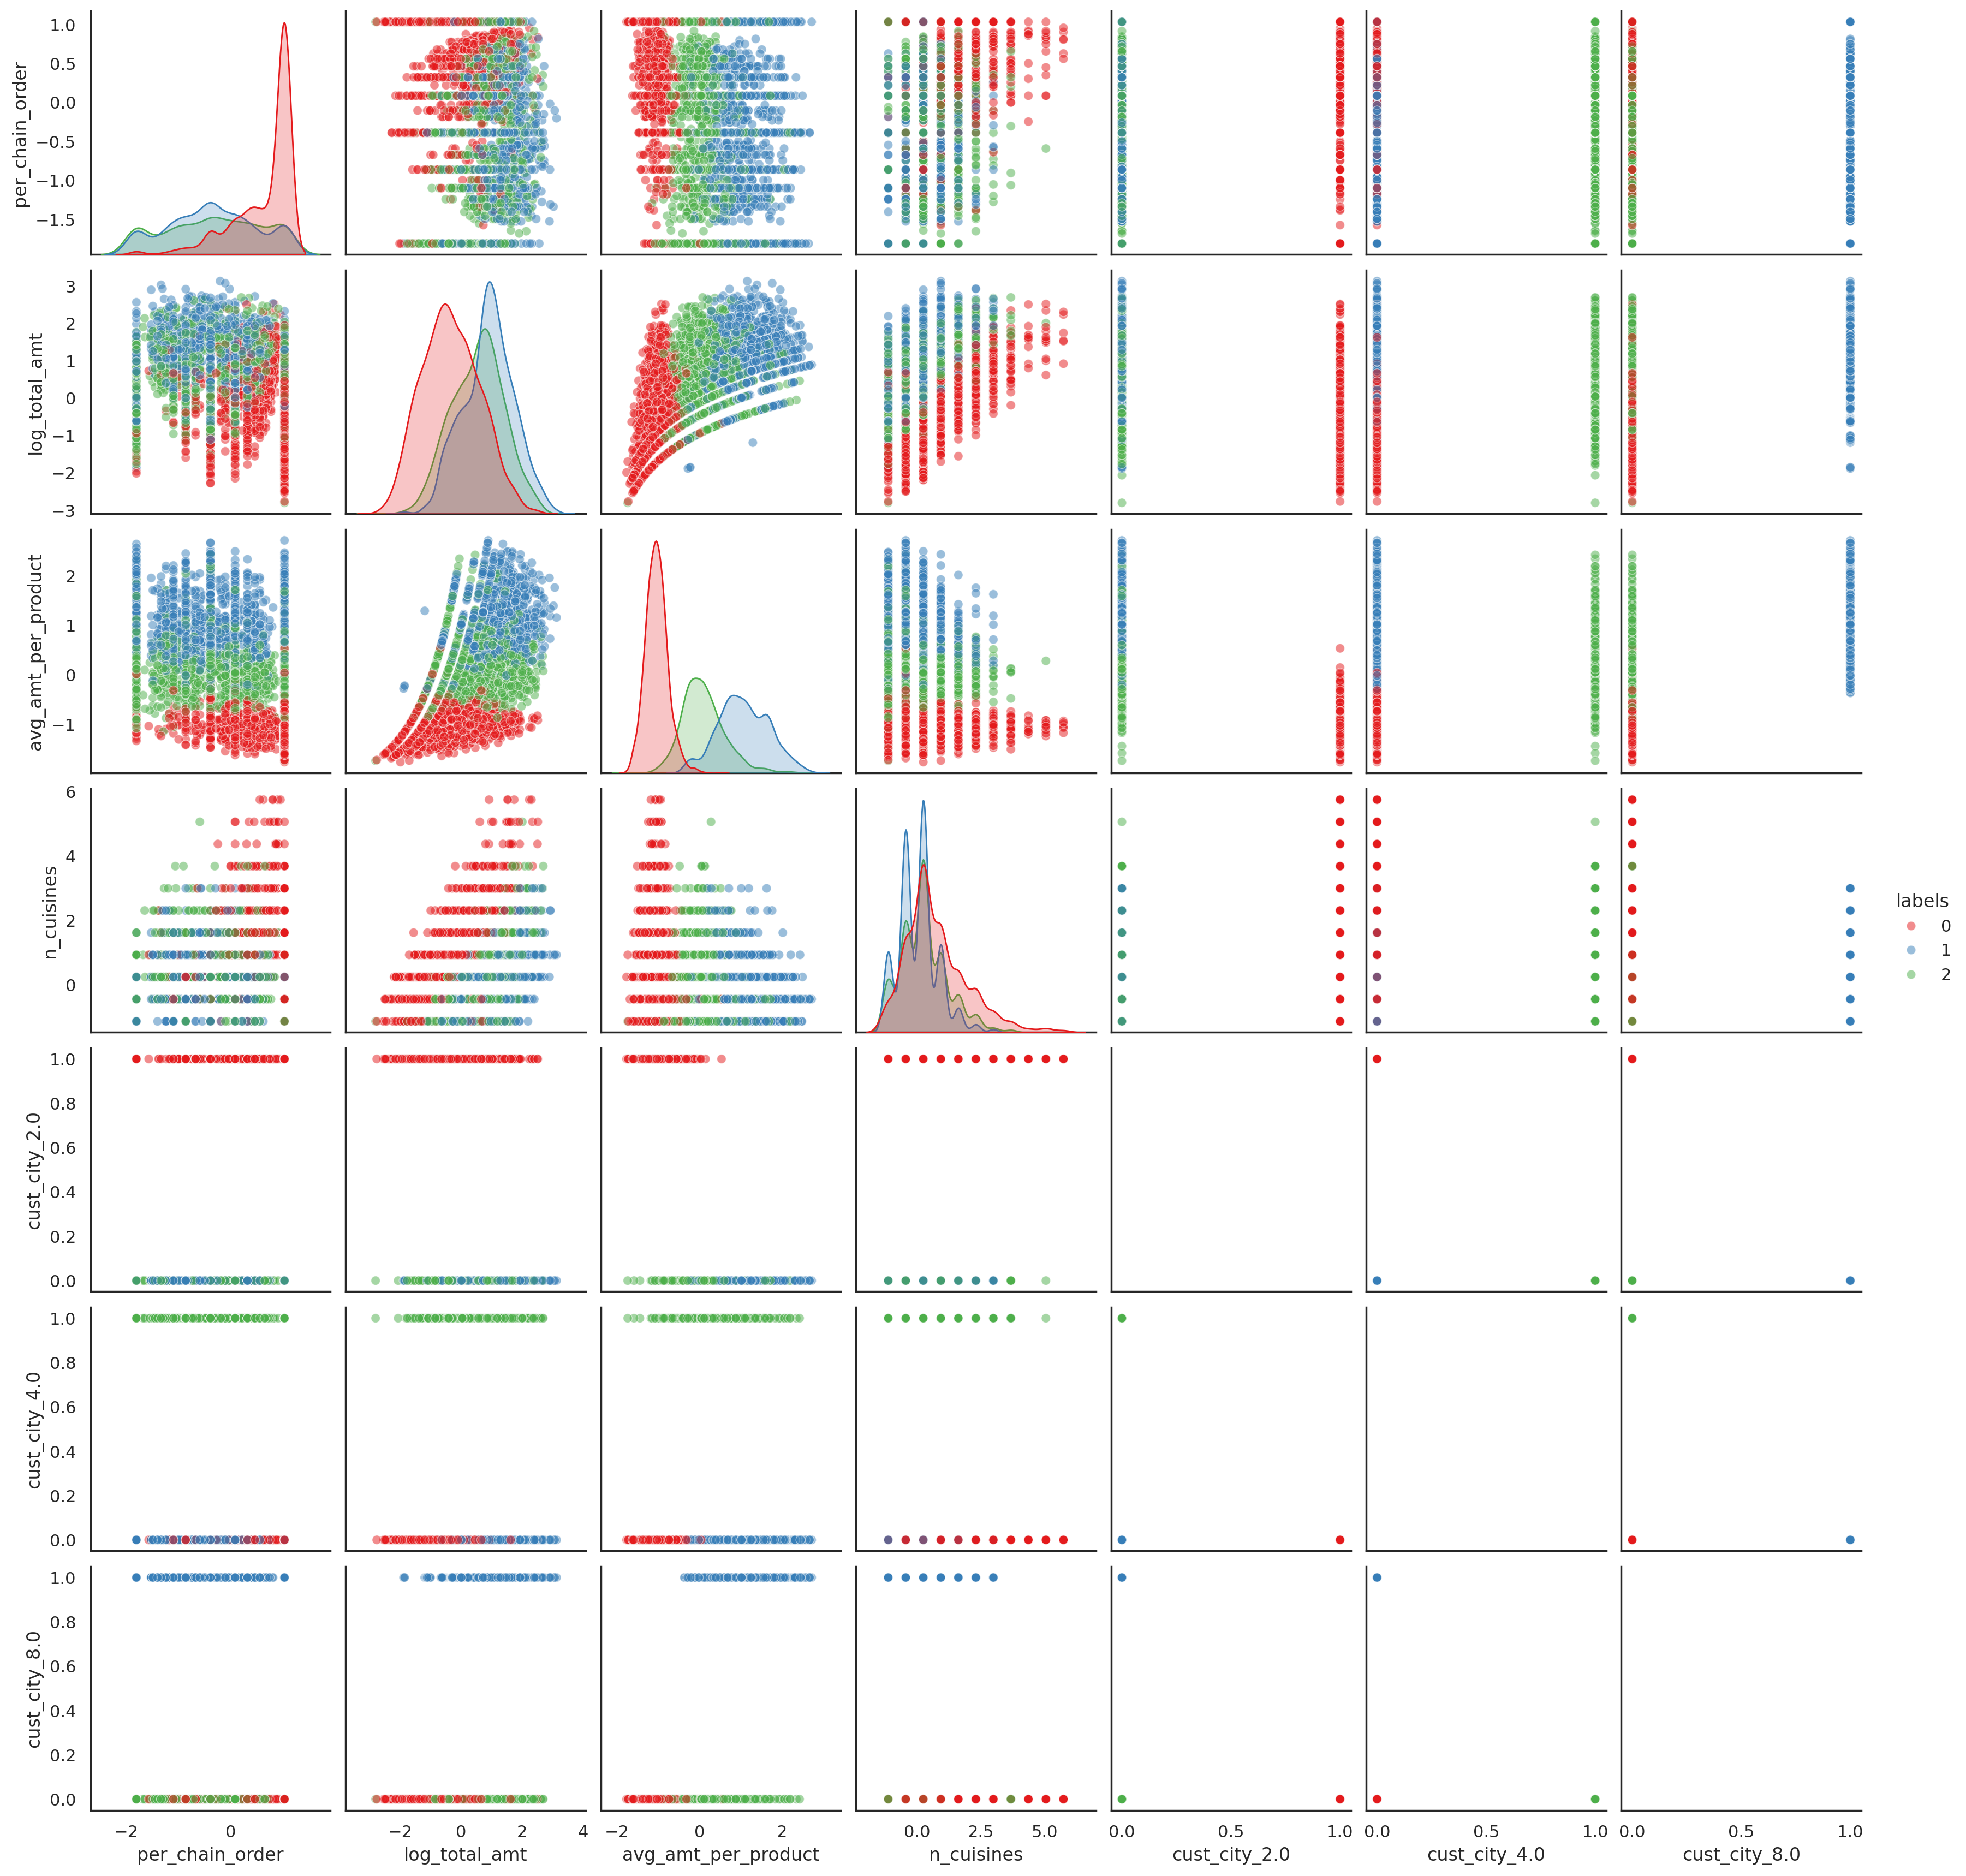

In [7]:
spectral = SpectralCluster(rbf_param=rbf_param, n_clusters=n_cluster)
spectral.fit(arr_spectral_df)

df = pd.DataFrame(arr_spectral_df, columns=target_features, index=spectral_df.index)

# Predict labels for each data point
df['labels'] = [spectral.predict(i) for i in range(len(arr_spectral_df))]

sns.pairplot(df, hue="labels", palette="Set1", plot_kws={'alpha':.5})

joblib.dump(spectral, 'spectral_clustering.pkl')

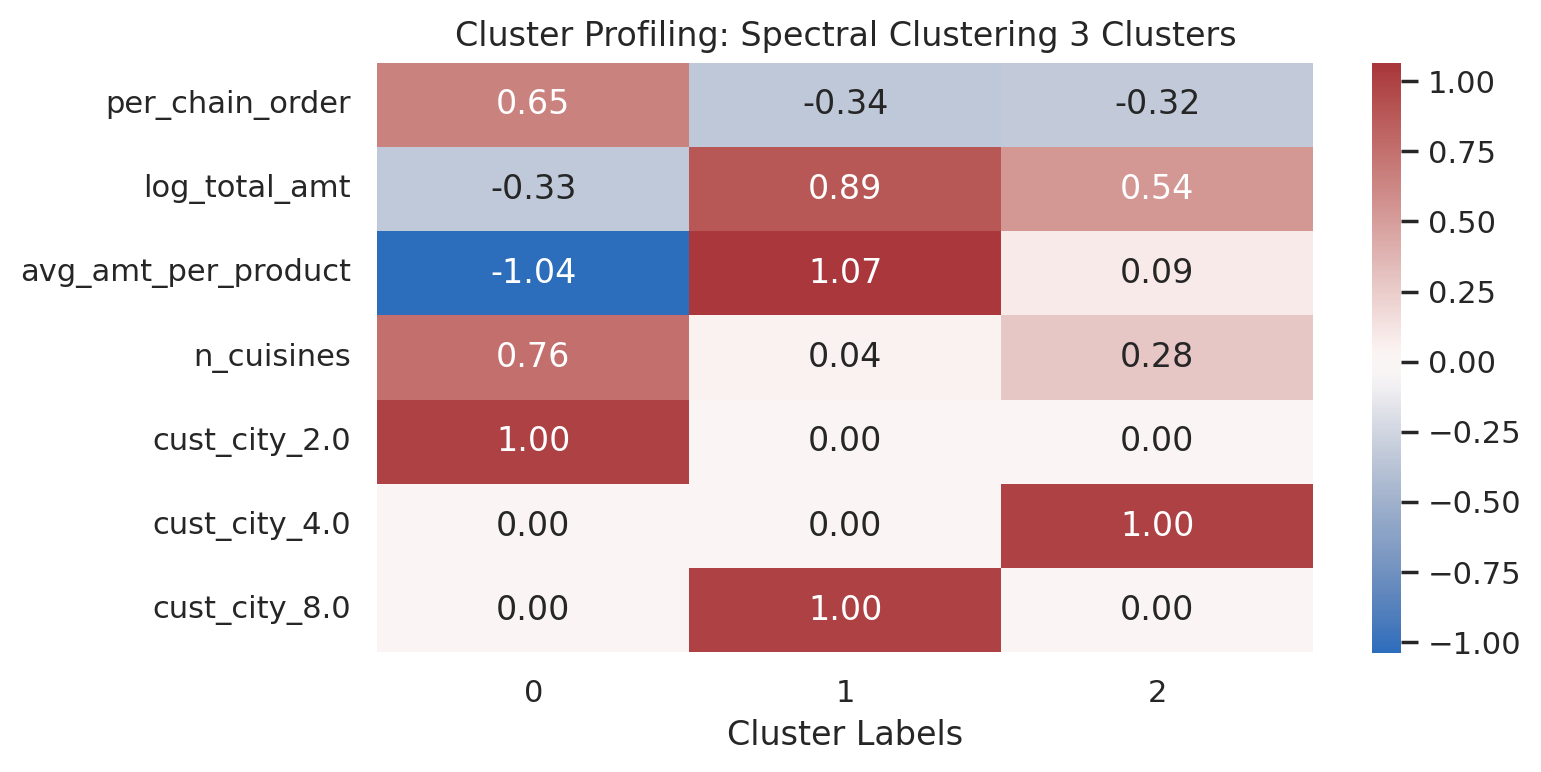

In [9]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling: Spectral Clustering {n_cluster} Clusters")

# Adjust layout to prevent clipping of labels
plt.tight_layout()

## Scoring

In [14]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df.drop(columns='labels'))  # get total sum of squares
ssw_labels = df.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

/tmp/ipykernel_23782/1605542028.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = df.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels


0.439552916770847

## Profiling

In [15]:
df.head()

,per_chain_order,log_total_amt,avg_amt_per_product,n_cuisines,cust_city_2.0,cust_city_4.0,cust_city_8.0,labels
customer_id,,,,,,,,
1065389230692,-0.387685,-2.108552,-1.359722,-0.438966,1.0,0.0,0.0,0
533160600035,1.033887,1.120359,-0.438840,-1.125804,0.0,1.0,0.0,2
812241166844,-0.387685,-1.561839,-0.874395,-0.438966,1.0,0.0,0.0,0
317872695537,0.323101,-0.336569,-0.691827,0.247872,1.0,0.0,0.0,0
152011672230,1.033887,1.194030,2.002067,-0.438966,0.0,0.0,1.0,1


In [16]:
# Create dataframe with profiling columns
sd_after_profiling = pd.merge(
    df
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        # +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [17]:
# Define the columns for each profile
profiling = {
    'Promotion': [col for col in sd_after_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in sd_after_profiling.columns if col.startswith('pay_method_')]
    # ,'City': [col for col in sd_after_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in sd_after_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in sd_after_profiling.columns if col.startswith('age_bucket_')]
}

joblib.dump(profiling, 'city_profiling.pkl')

['city_profiling.pkl']

In [ ]:
for profile, col in profiling.items():
    cluster_profile = sd_after_profiling.groupby('labels')[col].mean()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

## Explaining the Clusters

In [ ]:
# Load the scaler
scaler = joblib.load('std_scaler.pkl')

In [ ]:
numeric = [
    'cust_age', 'n_vendor', 'n_product', 'n_chain', 'first_order',
    'last_order', 'american', 'asian', 'beverages', 'cafe',
    'chicken_dishes', 'chinese', 'desserts', 'healthy', 'indian', 'italian',
    'japanese', 'noodle_dishes', 'other', 'street_food_snacks', 'thai',
    'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0',
    'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
    'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
    'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_amt',
    'n_order', 'avg_amt_per_product', 'avg_amt_per_order',
    'avg_amt_per_vendor', 'days_cust', 'avg_days_to_order', 'days_due',
    'per_chain_order', 'n_days_week', 'n_times_day', 'n_cuisines',
    'log_n_vendor', 'log_n_product', 'log_n_chain', 'log_american',
    'log_asian', 'log_beverages', 'log_cafe', 'log_chicken_dishes',
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

In [ ]:
# Revert the scaler
aux_unscaled_df = pd.DataFrame(scaler.inverse_transform(regulars[numeric]), columns=numeric, index=regulars.index)

In [ ]:
indices = df.index

In [ ]:
aux_unscaled_df = aux_unscaled_df.loc[indices]

In [ ]:
# Transform the dataset with unscaled values for easier interpretation
for col in ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']:
    df[col] = aux_unscaled_df[col]

In [ ]:
df.groupby('labels').agg(['min', 'max', 'mean'])

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df.groupby('labels').mean().T

sns.heatmap(hc_profile, center=0, annot=True, cmap="vlag", fmt=".2f", ax=ax)

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling: Spectral Clustering {n_clusters} unscaled")

plt.savefig('spectral_clusters_unscaled.png', format='png')

In [ ]:
# Define the size of the heatmap
fig_size = (10, 10)  # Width, Height in inches

# Set the figure size
plt.figure(figsize=fig_size)
correlation_matrix = np.corrcoef(df.T)

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", xticklabels=df.columns, yticklabels=df.columns)
plt.title('Feature Correlation Matrix')
plt.show()